<a href="https://colab.research.google.com/github/behigu/Pharmaceutical-Sales-prediction-across-multiple-stores/blob/main/notebooks/Pharmaceutical_Sales_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import warnings
warnings.filterwarnings('ignore')

import datetime
import math
import calendar

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
train = pd.read_csv('drive/MyDrive/ColabNotebooks/rossmann-store-sales/train.csv')
test = pd.read_csv('drive/MyDrive/ColabNotebooks/rossmann-store-sales/test.csv')
store = pd.read_csv('drive/MyDrive/ColabNotebooks/rossmann-store-sales/store.csv')

train.shape, test.shape, store.shape

((1017209, 9), (41088, 8), (1115, 10))

In [4]:
train.Store.nunique() == store.Store.nunique()

True

In [5]:
df = train.merge(store, how='left', left_on=train.Store, right_on=store.Store)
df.drop(['key_0', 'Store_y'], axis=1, inplace=True)
df = df.rename(columns={'Store_x':'Store'})
df.shape

(1017209, 18)

In [6]:
df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,7/31/2015,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,7/31/2015,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,7/31/2015,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,7/31/2015,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,7/31/2015,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [7]:
round(df.describe().T,2)

,count,mean,std,min,25%,50%,75%,max
Store,1017209.0,558.43,321.91,1.0,280.0,558.0,838.0,1115.0
DayOfWeek,1017209.0,4.00,2.00,1.0,2.0,4.0,6.0,7.0
Sales,1017209.0,5773.82,3849.93,0.0,3727.0,5744.0,7856.0,41551.0
Customers,1017209.0,633.15,464.41,0.0,405.0,609.0,837.0,7388.0
Open,1017209.0,0.83,0.38,0.0,1.0,1.0,1.0,1.0
Promo,1017209.0,0.38,0.49,0.0,0.0,0.0,1.0,1.0
SchoolHoliday,1017209.0,0.18,0.38,0.0,0.0,0.0,0.0,1.0
CompetitionDistance,1014567.0,5430.09,7715.32,20.0,710.0,2330.0,6890.0,75860.0
CompetitionOpenSinceMonth,693861.0,7.22,3.21,1.0,4.0,8.0,10.0,12.0
CompetitionOpenSinceYear,693861.0,2008.69,5.99,1900.0,2006.0,2010.0,2013.0,2015.0


In [8]:
train.duplicated().sum(), test.duplicated().sum()

(0, 0)

In [9]:
train.isnull().sum().sum(), test.isnull().sum().sum()

(0, 11)

In [10]:
print("Training data starts from: {}".format(train.Date.min()))
print("Training data end on: {}".format(train.Date.max()))
print()
print("Testing data starts from: {}".format(test.Date.min()))
print("Testing data end on: {}".format(test.Date.max()))

Training data starts from: 1/1/2013
Training data end on: 9/9/2014

Testing data starts from: 2015-08-01
Testing data end on: 2015-09-17


In [11]:
#get each day,month & year in the given date
df.Date = pd.to_datetime(df.Date)
df['Day'] = df.Date.dt.day
df['Month'] = df.Date.dt.month
df['Year'] = df.Date.dt.year

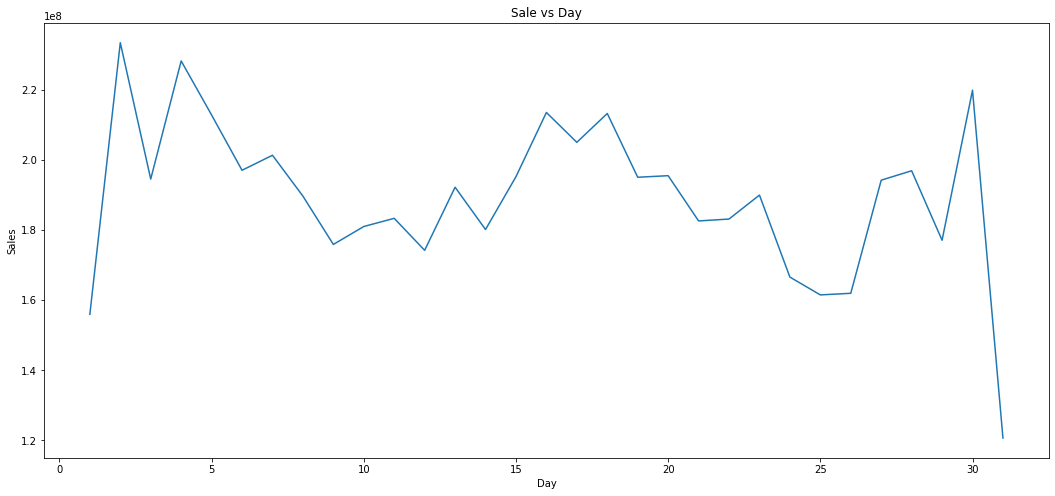

In [12]:
plt.figure(figsize=(18,8))
plt.plot(df.groupby(df.Day).sum().Sales)
plt.title("Sale vs Day")
plt.xlabel('Day')
plt.ylabel('Sales')
plt.show()

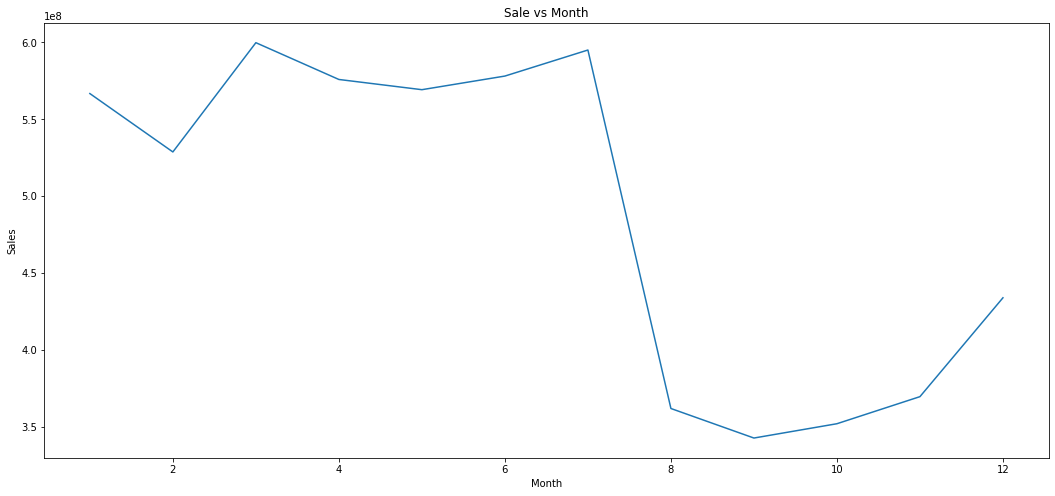

In [13]:
plt.figure(figsize=(18,8))
plt.plot(df.groupby(df.Month).sum().Sales)
plt.title("Sale vs Month")
plt.xlabel('Month')
plt.ylabel('Sales')
plt.show()

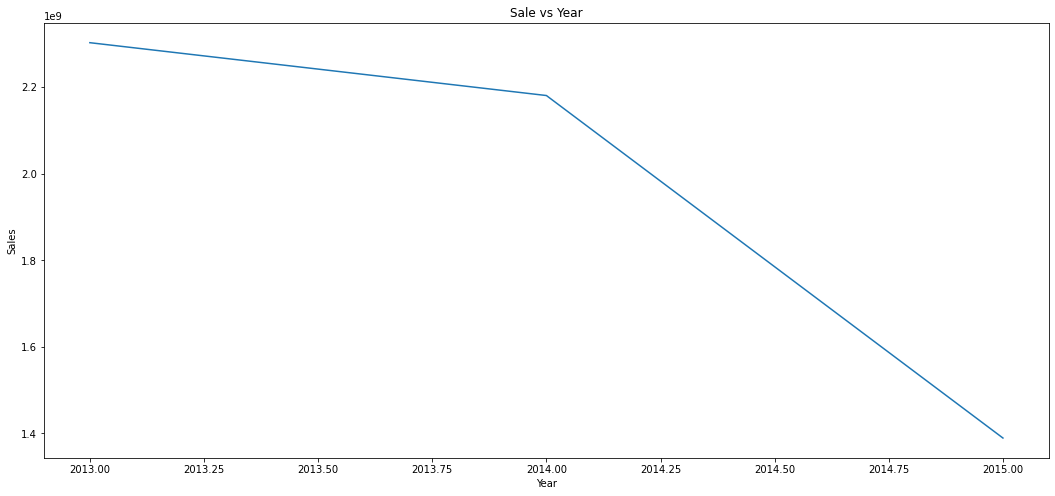

In [14]:
plt.figure(figsize=(18,8))
plt.plot(df.groupby(df.Year).sum().Sales)
plt.title("Sale vs Year")
plt.xlabel('Year')
plt.ylabel('Sales')
plt.show()

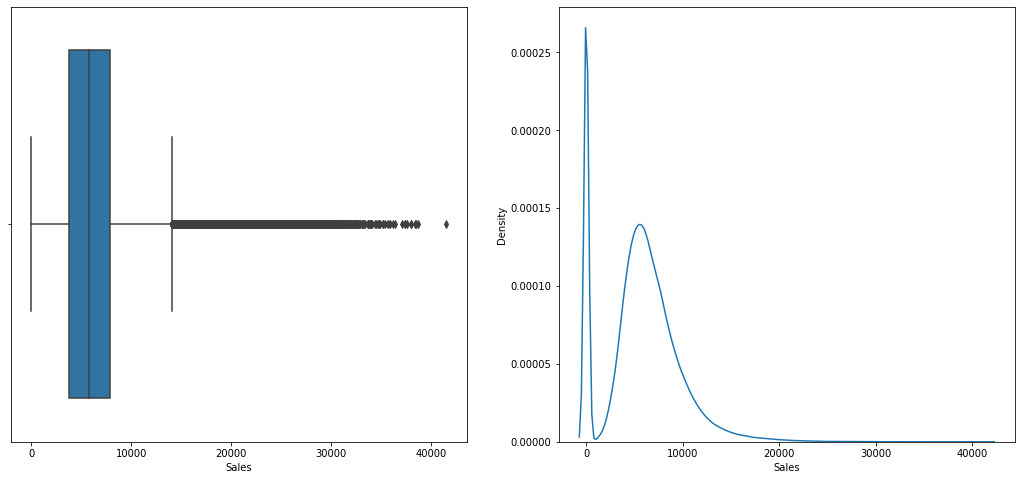

In [15]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18,8))
sns.boxplot(train.Sales, ax=ax1)
sns.kdeplot(train.Sales, ax=ax2)
plt.show()

Sales are 0 on a huge amount of days which could mean this is either imputed to fill gaps as it doesn't make sense for sale of a day to be 0. It could mean the store was closed, maybe there was a holiday. Lets see if this stands.

In [16]:
df[df.Open==0].Sales.value_counts()

0    172817
Name: Sales, dtype: int64

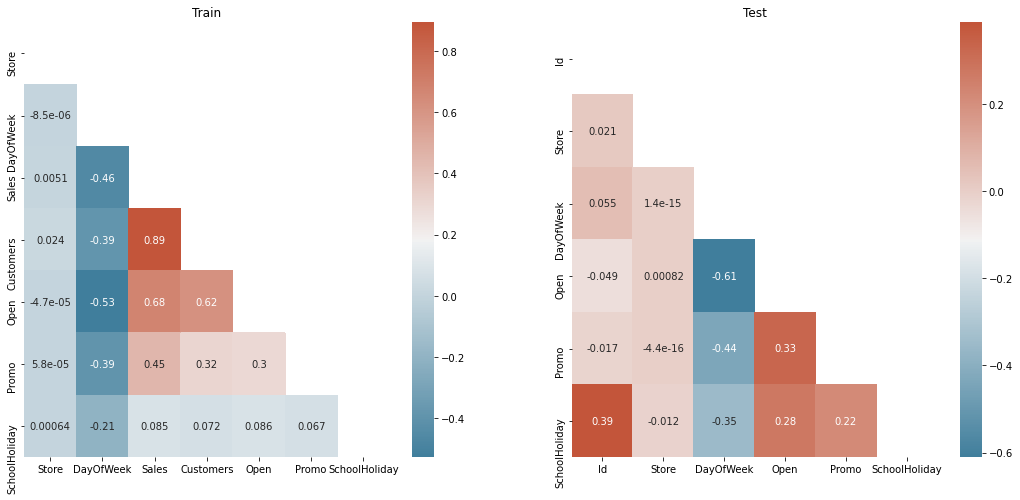

In [17]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18,8))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
corr = train.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(train.corr(), mask=mask, cmap=cmap, annot=True, ax=ax1)
ax1.set_title('Train')
corr = test.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(test.corr(), mask=mask, cmap=cmap, annot=True, ax=ax2)
ax2.set_title('Test')
plt.show()

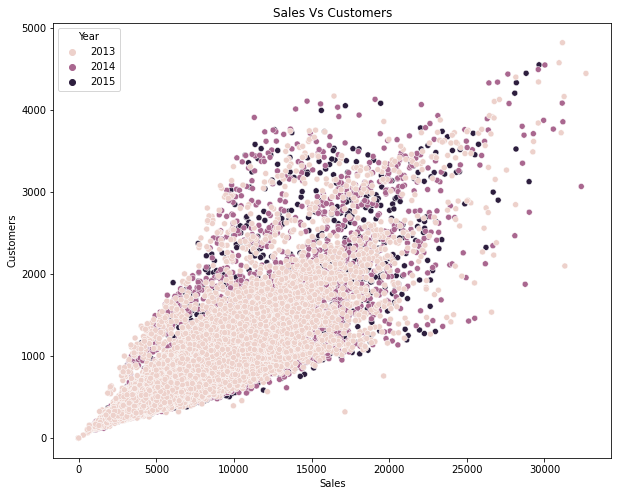

In [18]:
temp_df = df.sample(100000)
plt.figure(figsize=(10,8))
sns.scatterplot(temp_df.Sales, temp_df.Customers, hue=df.Year, )
plt.title("Sales Vs Customers")
plt.show()

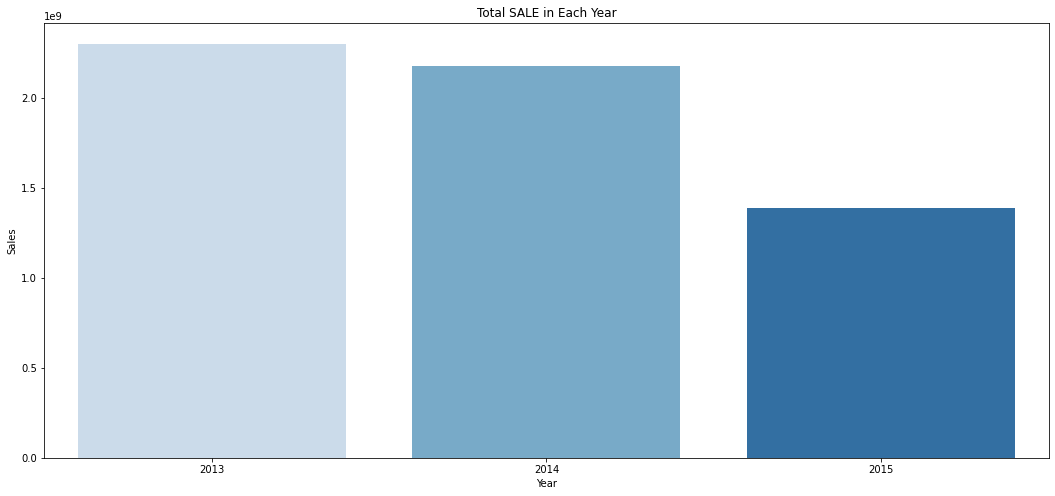

In [19]:
plt.figure(figsize=(18,8))
temp_df = df.groupby(df.Year).sum()
sns.barplot(temp_df.index, temp_df.Sales, palette='Blues')
plt.title("Total SALE in Each Year")
plt.xlabel('Year')
plt.ylabel('Sales')
plt.show()


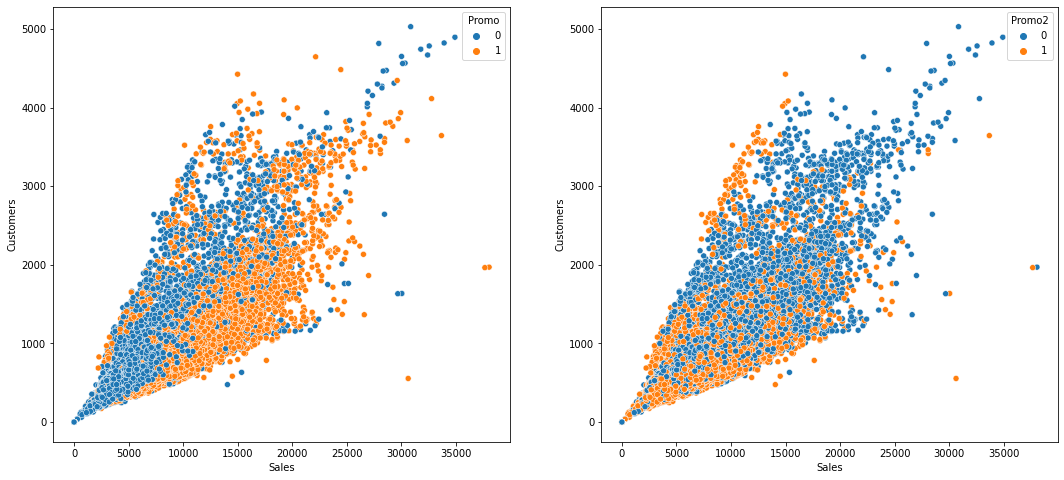

In [20]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18,8))
temp_df = df.sample(100000)
sns.scatterplot(temp_df.Sales, temp_df.Customers, hue=df.Promo, ax=ax1)
sns.scatterplot(temp_df.Sales, temp_df.Customers, hue=df.Promo2, ax=ax2)
plt.show()

In [21]:
df.groupby(df.Promo).Sales.mean()[1] > df.groupby(df.Promo2).Sales.mean()[1] #1 means store participated

True

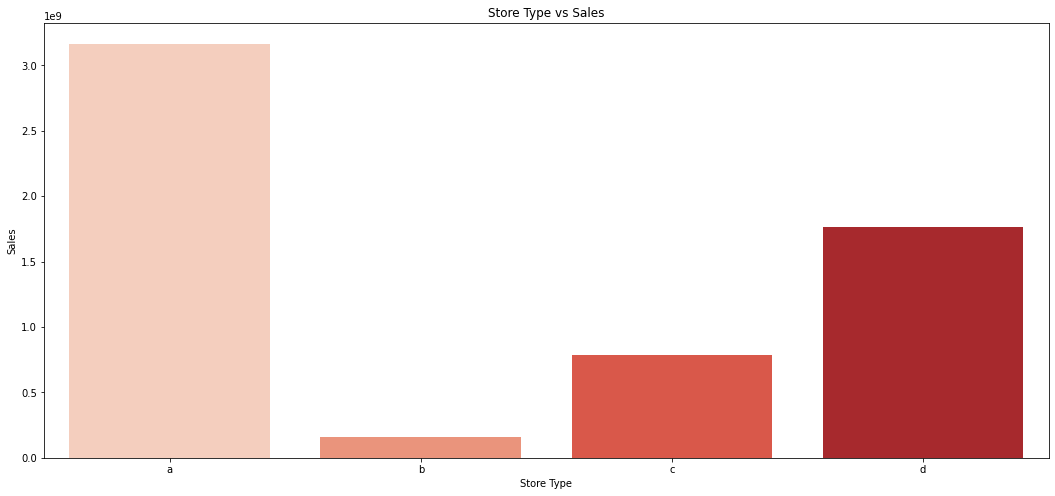

In [22]:
plt.figure(figsize=(18,8))
temp_df = df.groupby(df.StoreType).sum()
sns.barplot(temp_df.index, temp_df.Sales, palette='Reds')
plt.title("Store Type vs Sales")
plt.xlabel('Store Type')
plt.ylabel('Sales')
plt.show()

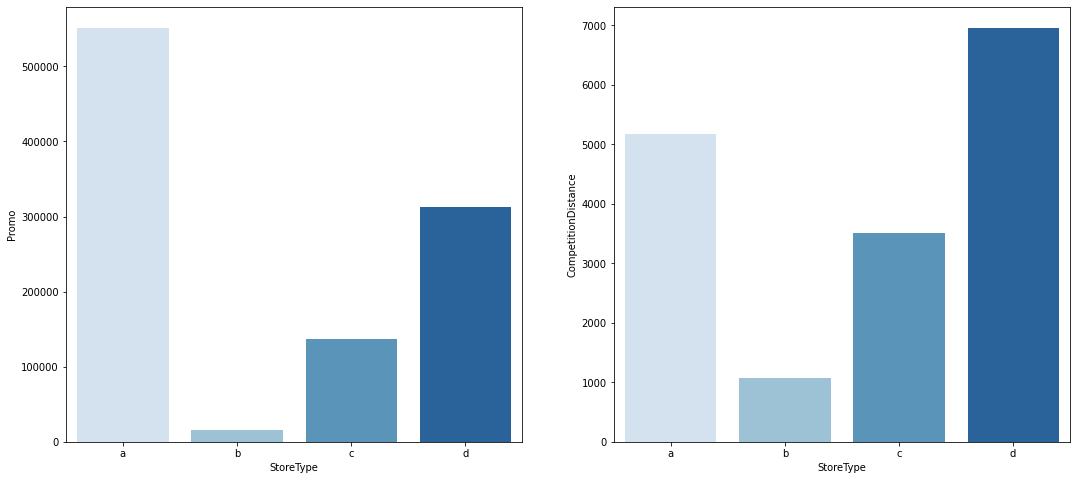

In [23]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18,8))
temp_df = df.groupby(df.StoreType).count()
sns.barplot(temp_df.index, temp_df['Promo'], ax=ax1, palette='Blues')
temp_df = df.groupby(df.StoreType).mean()
sns.barplot(temp_df.index, temp_df['CompetitionDistance'], ax=ax2, palette='Blues')
plt.show()

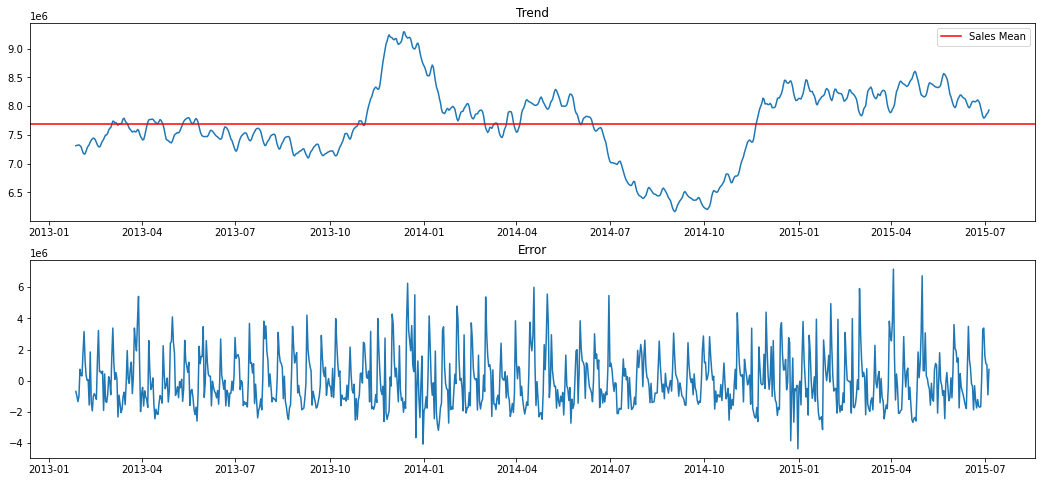

In [24]:
from statsmodels.tsa.seasonal import seasonal_decompose
temp_df = train.copy()
temp_df.Date = pd.to_datetime(temp_df.Date)
temp_df.index = temp_df.Date
temp_df.Sales = temp_df.Sales.apply(lambda x: None if x == 0 else x)
temp_df.Sales = temp_df.Sales.fillna(method='ffill').fillna(method='bfill')
temp_df = temp_df[['Sales']]
temp_df = temp_df.groupby(temp_df.index).sum()
result = seasonal_decompose(temp_df, model='additive', freq=52)

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(18,8))
ax1.plot(result.trend)
ax1.axhline(y = temp_df.Sales.mean(), color = 'r', linestyle = '-', label='Sales Mean')
ax1.set_title("Trend")
ax2.plot(result.resid)
ax2.set_title("Error")
ax1.legend()
plt.show()


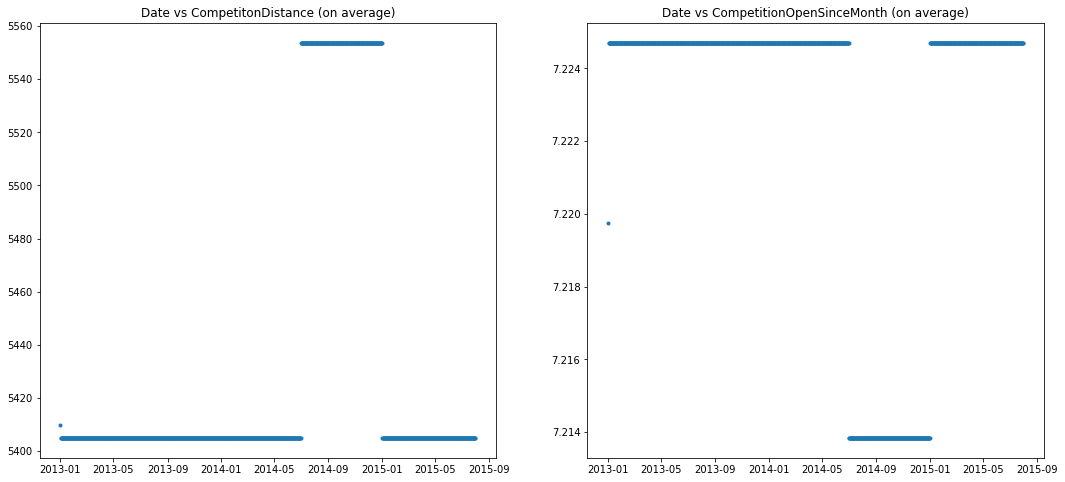

In [25]:
temp_df = df.copy()
temp_df.index = temp_df.Date
temp_df.Sales = temp_df.Sales.apply(lambda x: None if x == 0 else x)
temp_df.Sales = temp_df.Sales.fillna(method='ffill').fillna(method='bfill')
temp_df = temp_df.groupby(temp_df.index).mean()

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18,8))
ax1.plot(temp_df.CompetitionDistance, '.')
ax1.set_title("Date vs CompetitonDistance (on average)")
ax2.plot(temp_df.CompetitionOpenSinceMonth, '.')
ax2.set_title("Date vs CompetitionOpenSinceMonth (on average)")
plt.show()

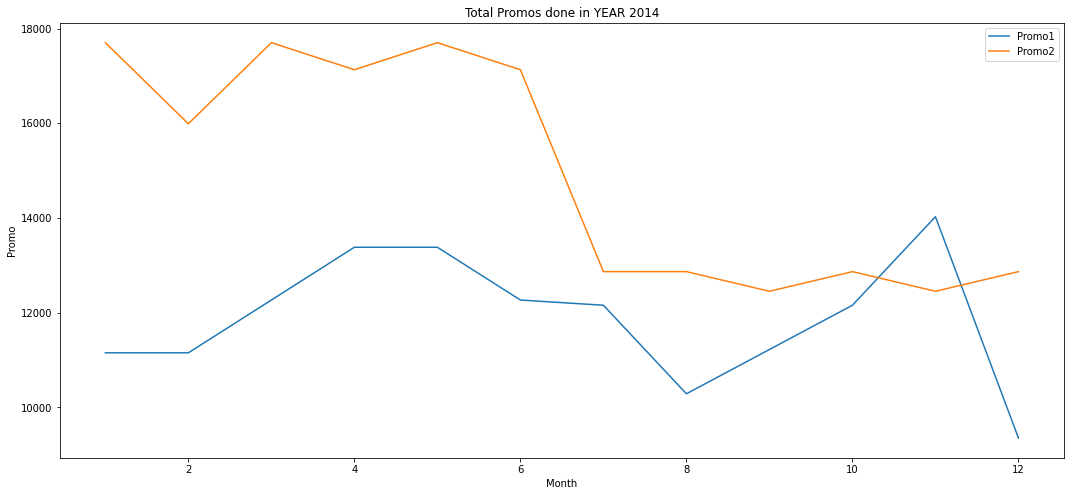

In [26]:
plt.figure(figsize=(18,8))
temp_df = df.copy()
temp_df.index = temp_df.Date
temp_df = temp_df[temp_df.Year==2014]
temp_df = temp_df.groupby(temp_df.Month).sum()
temp_df.Sales = temp_df.Sales.apply(lambda x: None if x == 0 else x)
temp_df.Sales = temp_df.Sales.fillna(method='ffill').fillna(method='bfill')

plt.title('Total Promos done in YEAR 2014')
sns.lineplot(temp_df.index, temp_df.Promo, palette='Blues', label='Promo1')
sns.lineplot(temp_df.index, temp_df.Promo2, palette='Blues', label='Promo2')
plt.legend()
plt.show()

Feature Engineering and Preprocessing

In [27]:
features_x = ['Store', 'Date', 'DayOfWeek', 'Open', 'Promo', 'SchoolHoliday', 'StateHoliday']
features_y = ['SalesLog']

In [28]:
train['is_train'] = 1
test['is_train'] = 0
df = pd.concat([train, test])

In [29]:
df.Date = pd.to_datetime(df.Date) #Converting date to required format

In [30]:
df = df.loc[~((df['Open'] == 1) & (df['Sales'] == 0))] #Removing rows with Sales 0

In [31]:
df.StateHoliday = df.StateHoliday.map({0:'0', 'a':'a', 'b':'b', 'c':'c', '0':'0'}) #mixed data types
df.StateHoliday = LabelEncoder().fit_transform(df.StateHoliday) #Encoding for XG Boost

In [32]:
var_name = 'Date'

df[var_name + 'Day'] = df[var_name].dt.day #addding day
df[var_name + 'Week'] = df[var_name].dt.week #adding week
df[var_name + 'Month'] = df[var_name].dt.month #adding month
df[var_name + 'Year'] = df[var_name].dt.year #adding year
df[var_name + 'DayOfYear'] = df[var_name].dt.dayofyear #adding dayofyear

features_x.remove(var_name) #removing Date
features_x.append(var_name + 'Day')
features_x.append(var_name + 'Week')
features_x.append(var_name + 'Month')
features_x.append(var_name + 'Year')
features_x.append(var_name + 'DayOfYear')


In [33]:
store.StoreType = LabelEncoder().fit_transform(store.StoreType) #encoding StoreType
store.Assortment = LabelEncoder().fit_transform(store.Assortment) 

In [34]:
join_with = store['PromoInterval'].str.split(',').apply(pd.Series)
join_with.columns = join_with.columns.map(lambda x: str(x) + '_PromoInterval')
store = store.join(join_with) #joining splits

In [35]:
def monthToNum(value):
    if(value=='Sept'):
        value='Sep'
    return list(calendar.month_abbr).index(value)
#mapping month abbr to month number
store['0_PromoInterval'] = store['0_PromoInterval'].map(lambda x: monthToNum(x) if str(x) != 'nan' else np.nan)
store['1_PromoInterval'] = store['1_PromoInterval'].map(lambda x: monthToNum(x) if str(x) != 'nan' else np.nan)
store['2_PromoInterval'] = store['2_PromoInterval'].map(lambda x: monthToNum(x) if str(x) != 'nan' else np.nan)
store['3_PromoInterval'] = store['3_PromoInterval'].map(lambda x: monthToNum(x) if str(x) != 'nan' else np.nan)

In [36]:
competition_open = []
for index, value in store[['CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear']].iterrows():
    try:
        year, month = int(value['CompetitionOpenSinceYear']), int(value['CompetitionOpenSinceMonth'])
        date = pd.to_datetime("{}-{}-01".format(year, month), format='%Y-%m')
        competition_open.append(date)
    except:
        competition_open.append(np.nan)
competition_open = pd.Series(competition_open)
competition_open.shape

(1115,)

In [37]:
store['CompetitionOpen'] = competition_open #converted int to datetime
store['CompetitionOpen'] = store.CompetitionOpen.dt.strftime('%Y%m%d')

In [38]:
promo = []
for index, value in store[['Promo2SinceWeek', 'Promo2SinceYear']].iterrows():
    try:
        year, week = int(value['Promo2SinceYear']), int(value['Promo2SinceWeek'])
        date = pd.to_datetime("{}-{}-01".format(year, week), format='%Y%W')
        promo.append(date)
    except:
        promo.append(np.nan)
promo = pd.to_datetime(pd.Series(competition_open))
promo.shape

(1115,)

In [39]:
store['PromoSince'] = promo #converted int to datetime
store['PromoSince'] = store.PromoSince.dt.strftime('%Y%m%d')

In [40]:
store_features = ['Store', 'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpen', 
                  'PromoSince', '0_PromoInterval']
#1_PromoInterval, 2_PromoInterval, 3_PromoInterval irrelevent

In [41]:
df = pd.merge(df, store[store_features], how='left', on=['Store'])

In [42]:
features_x = list(set(features_x + store_features))

In [43]:
for feature in features_x:
    df[feature] = df[feature].fillna(-999) #out of range value for model

In [44]:
df['DateInt'] = df.Date.dt.strftime('%Y%m%d').map(int) #mapping to Int
df['CompetitionOpen'] = df.CompetitionOpen.map(int)
df['PromoSince'] = df.PromoSince.map(int)

In [45]:
df['Zscore'] = (df.Sales - df.Sales.mean())/df.Sales.std()

In [46]:
thresh=4.0
def check_outlier(value):
    if(value>=thresh):
        return True
    else:
        return False

df['Outlier'] = df.Zscore.apply(check_outlier)

In [47]:
store_data_sales = df.groupby([df['Store']])['Sales'].sum()
store_data_customers = df.groupby([df['Store']])['Customers'].sum()
store_data_open = df.groupby([df['Store']])['Open'].count()

store_data_sales_per_day = store_data_sales / store_data_open
store_data_customers_per_day = store_data_customers / store_data_open
store_data_sales_per_customer_per_day = store_data_sales_per_day / store_data_customers_per_day

df_store = pd.merge(store, store_data_sales_per_day.reset_index(name='SalesPerDay'), how='left', on=['Store'])
df_store = pd.merge(df_store, store_data_customers_per_day.reset_index(name='CustomersPerDay'), how='left', on=['Store'])
df_store = pd.merge(df_store, store_data_sales_per_customer_per_day.reset_index(name='SalesPerCustomersPerDay'), how='left', on=['Store'])
store_features = ['Store', 'SalesPerDay', 'CustomersPerDay', 'SalesPerCustomersPerDay']

features_x = list(set(features_x + store_features))
df = pd.merge(df, df_store[store_features], how='left', on=['Store'])

In [48]:
holidays_each_day_of_week = df.groupby(df.DayOfWeek).sum().StateHoliday
df = pd.merge(df, holidays_each_day_of_week.reset_index(name='HolidaysPerDayOfWeek'), on=['DayOfWeek'])

In [49]:
school_holidays_each_day_of_week = df.groupby(df.DayOfWeek).sum().SchoolHoliday
df = pd.merge(df, school_holidays_each_day_of_week.reset_index(name='SchoolHolidaysPerDayOfWeek'), on=['DayOfWeek'])

In [50]:
promo_each_day_of_week = df.groupby(df.DayOfWeek).sum().Promo
df = pd.merge(df, promo_each_day_of_week.reset_index(name='PromoPerDayOfWeek'), on=['DayOfWeek'])

In [51]:
holidays_next_week=[]
holidays_next_week_index=[]
for index, value in df.groupby(df.Date).sum().iterrows():
    start_range = index + datetime.timedelta(days=7)
    end_range = index + datetime.timedelta(days=15)
    school_holidays = sum((df.groupby(df.Date).sum()[start_range:end_range]).SchoolHoliday)
    state_holidays = sum((df.groupby(df.Date).sum()[start_range:end_range]).StateHoliday)
    holidays_next_week.append(school_holidays+state_holidays)
    holidays_next_week_index.append(index)
    
holidays_next_week = pd.Series(holidays_next_week)
holidays_next_week.shape

(990,)

In [52]:
holidays_this_week=[]
index_list = []
for index, value in df.groupby(df.Date).sum().iterrows():
    start_range = index 
    end_range = index + datetime.timedelta(days=7)
    school_holidays = sum((df.groupby(df.Date).sum()[start_range:end_range]).SchoolHoliday)
    state_holidays = sum((df.groupby(df.Date).sum()[start_range:end_range]).StateHoliday)
    holidays_this_week.append(school_holidays+state_holidays)
    index_list.append(index)
    
holidays_this_week = pd.Series(holidays_this_week)
holidays_this_week.shape

(990,)

In [ ]:
holidays_last_week=[]
holidays_last_week_index=[]
for index, value in df.groupby(df.Date).sum().iterrows():
    start_range = index - datetime.timedelta(days=7)
    end_range = index + datetime.timedelta(days=1)
    school_holidays = sum((df.groupby(df.Date).sum()[start_range:end_range]).SchoolHoliday)
    state_holidays = sum((df.groupby(df.Date).sum()[start_range:end_range]).StateHoliday)
    holidays_last_week.append(school_holidays+state_holidays)
    holidays_last_week_index.append(index)
    
holidays_last_week = pd.Series(holidays_next_week)
holidays_last_week.shape

In [ ]:
temp_df = pd.DataFrame({'HolidaysNextWeek':holidays_next_week, 'Date': holidays_next_week_index})
df = pd.merge(df, temp_df, on=['Date'])

In [ ]:
temp_df = pd.DataFrame({'HolidaysThisWeek':holidays_this_week, 'Date': index_list})
df = pd.merge(df, temp_df, on=['Date'])

In [ ]:
temp_df = pd.DataFrame({'HolidaysLastWeek':holidays_last_week, 'Date': holidays_last_week_index})
df = pd.merge(df, temp_df, on=['Date'])

In [ ]:
holidays_features = ['HolidaysPerDayOfWeek', 'SchoolHolidaysPerDayOfWeek', 'PromoPerDayOfWeek', 
                     'HolidaysNextWeek', 'HolidaysThisWeek', 'HolidaysLastWeek']

features_x = list(set(features_x + holidays_features))

In [ ]:
#Most Promos are done on DayofWeek 4
df['DaysTillMaxPromo'] = df.DayOfWeek.apply(lambda x: 4-x)

In [ ]:
df['PromoTomorrow'] = df.Promo.shift(-1)
df['PromoYesterday'] = df.Promo.shift(1)

In [ ]:
promo_features = ['DaysTillMaxPromo', 'PromoTomorrow', 'PromoYesterday']

features_x = list(set(features_x + promo_features))

In [ ]:
df.Sales = df.Sales.apply(lambda x: np.nan if x == 0 else x) #Convert 0 to NaNs

In [ ]:
df.loc[df['is_train'] == 1, 'SalesLog'] = np.log(1+df.loc[df['is_train'] == 1]['Sales']) #Transforming Sales to 1+log

In [ ]:
len(features_x)

In [ ]:
df.shape

In [ ]:
df.isnull().sum().sum()

Modelling